In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import tables
import scipy.sparse as sp
import anndata
from typing import Dict, Optional

sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [6]:
#Needed as scanpy cannot load in cellranger matrix

def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]

    return adata


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

In [17]:
#Filtering, UMI cutoffs, normalization, PCA, Neighbors, UMAP calculations
#Usage: sample = sample_name, res = leiden cluster resolution (1 is default)
def preprocess(sample, res):
    #read adata and specify results file
    results_file = '/home/apennacchio/pcsct/data/preprocessed/' + sample + '.h5ad'
    adata = anndata_from_h5(file='/home/apennacchio/pcsct/data/cellbender/' + sample + '/' + sample + '_filtered.h5')
    
    #remove gene: prefix from all gene names
    new_gene_names_in_correct_order = [id[5:] if id[0:5]=='gene:' else id for id in adata.var_names]
    adata.var_names = new_gene_names_in_correct_order
    
    adata.var_names_make_unique()

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    if(sample[0:3] == 'sbi'):
        print("Sorghum UMI cutoffs")
        sc.pp.filter_cells(adata, min_counts=1200)
        sc.pp.filter_cells(adata, max_counts=80000)
    elif(sample[0:3] == 'zma'):
        print("Maize UMI cutoffs")
        sc.pp.filter_cells(adata, min_counts=2000)
        sc.pp.filter_cells(adata, max_counts=200000)
    elif (sample[0:3] == 'ath'):
        print("A.Thaliana UMI cutoffs")
        sc.pp.filter_cells(adata, min_counts=10000)
        sc.pp.filter_cells(adata, max_counts=400000)
        
    #normalize
    sc.pp.normalize_total(adata, target_sum=1e4)

    #PCA, Neighborhood, Leiden, UMAP
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40) 
    sc.tl.leiden(adata, resolution=res)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='leiden')
    adata.write(results_file)

    return adata




In [22]:
#used to merge same-species samples using scanpy ingest. Works better than harmonypy in my experience. 
#currently merges zmays2 and 3 together, using zmays2 as a reference. 
#usage: pass array of adata objects to integrate, first object is used as reference, output is merged adata
def ingest_samples(arr):
    ref = arr[0]
    dat = arr[1]
    ref.obs['Sample'] = '2'
    dat.obs['Sample'] = '3'
    var_names = ref.var_names.intersection(dat.var_names)
    dat = dat[:, var_names]
    ref = ref[:, var_names]
    sc.tl.ingest(dat, ref, obs='leiden')
    ref = attach_CT(ref, "zmays_root2")
    dat = attach_CT(dat, "zmays_root3")
    merged = ref.concatenate(dat)
    merged.write('/home/apennacchio/pcsct/data/preprocessed/integrated_zmays23.h5ad')

    return merged

In [23]:
#usage: pass adata and sample name as inputs, output is adata with cell type labels attached (unlabeled cells are removed)
def attach_CT(adata, sample):
    results_file = '/home/apennacchio/pcsct/data/preprocessed/' + sample + '.h5ad'
    
    #load in birnbaum dataframe, consisting of barcodes, labels, species, and sample source
    #note that only contains sorghum + maize cell types, have not yet extracted arabadopsis CT labels
    df = pd.read_csv('/home/apennacchio/pcsct/R_scripts/labels.csv')
    sources = []
    
    #Remove cell subtypes
    df['lab'].replace(['Cortex_1', 'Cortex_2', 'Cortex_3', 'Cortex_4'], 'Cortex', inplace=True)
    df['lab'].replace(['Epidermis_1', 'Epidermis_2', 'Epidermis_3'], 'Epidermis', inplace=True)
    df['lab'].replace(['Young_Stele_2'], 'YoungStele', inplace=True)
    df['lab'].replace(['Stele_2', 'Stele_1'], 'Stele', inplace=True)
    df['lab'].replace(['Young_Phloem'], 'YoungPhloem', inplace=True)
    df['lab'].replace(['G2_M'], 'G2', inplace=True)
   
    if(sample[0:3] == 'sbi'):
        df = df.loc[df['species'].str.contains("Sorghum")]
        sources = ["Sorghum_Cell_", "Sorghum_Nucl1_", "Sorghum_Nucl2_", "Sorghum_Nucl3_"]
    elif(sample[0:3] == 'zma'):
        df = df.loc[df['species'].str.contains("Maize")]
        sources = ["Maize_Cell1_", "Maize_Cell2_", "Maize_Cell3_", "Maize_Cell4_", "Maize_Nucl1_", "Maize_Nucl2_", "Maize_Nucl3_", "Maize_Nucl4_"]
    
        
    df = df.drop(["species"], axis=1)
    df["source"] = ""    

    for i in sources:
        mask = df['barcodes'].str.contains(i)
        df['barcodes'] = df['barcodes'].str.replace(i, "")
        df.loc[mask, 'source'] = i
        
    df = df.set_index("barcodes")
    
    #drop cells that do not have labels from adata
    intersection = np.intersect1d(adata.obs.index, df.index)
    df = df.loc[intersection]
    df = df[~df.index.duplicated()]
    adata = adata[intersection]
    adata.obs = adata.obs.join(df, how='inner')
    adata.write(results_file)
    
    sc.pl.umap(adata, color='lab')
    
    return adata


In [24]:
#makes input csv file for saturn using preprocessed matrices listed above, need to change paths if using different samples
def make_csv():
    #create csv containing h5 files, species, and protein embeddings as per SATURN's input requirements

    df = pd.DataFrame(columns=["path", "species", "embedding_path"])

    #species
    df["species"] = ["sorghum", "zmays"]

    #h5 file
    df["path"] = ["/home/apennacchio/pcsct/data/preprocessed/sbicolor_root10.h5ad",
        "/home/apennacchio/pcsct/data/preprocessed/integrated_zmays23.h5ad",
        ]

    #protein embeddings
    sorghum_embedding_path = "/home/apennacchio/SATURN/protein_embeddings/proteome/embeddings/Sorghum_bicolor_NCBIv3.gene_symbol_to_embedding_ESM1b.pt"
    zmays_embedding_path = "/home/apennacchio/SATURN/protein_embeddings/proteome/embeddings/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.gene_symbol_to_embedding_ESM1b.pt"
    df["embedding_path"] = [sorghum_embedding_path, zmays_embedding_path]

    #save csv location
    df.to_csv("/home/apennacchio/pcsct/saturn/s10_z23.csv",index=False) 

Assuming we are loading a "filtered" file that contains only cells.
filtered out 17 cells that have less than 200 genes expressed
filtered out 11075 genes that are detected in less than 3 cells
Sorghum UMI cutoffs
filtered out 354 cells that have less than 1200 counts
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


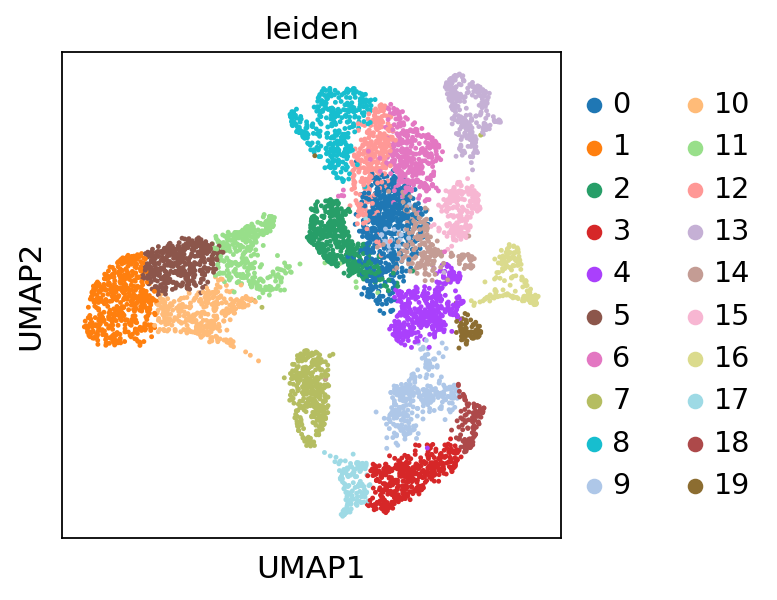

Assuming we are loading a "filtered" file that contains only cells.
filtered out 1 cells that have less than 200 genes expressed
filtered out 10878 genes that are detected in less than 3 cells
Maize UMI cutoffs
filtered out 72 cells that have less than 2000 counts
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


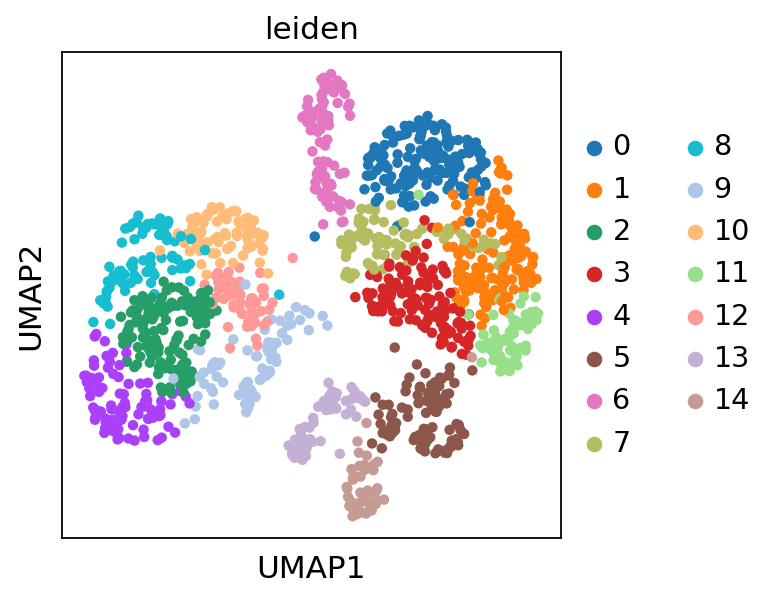

Assuming we are loading a "filtered" file that contains only cells.
filtered out 11 cells that have less than 200 genes expressed
filtered out 18450 genes that are detected in less than 3 cells
Maize UMI cutoffs
filtered out 5131 cells that have less than 2000 counts
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


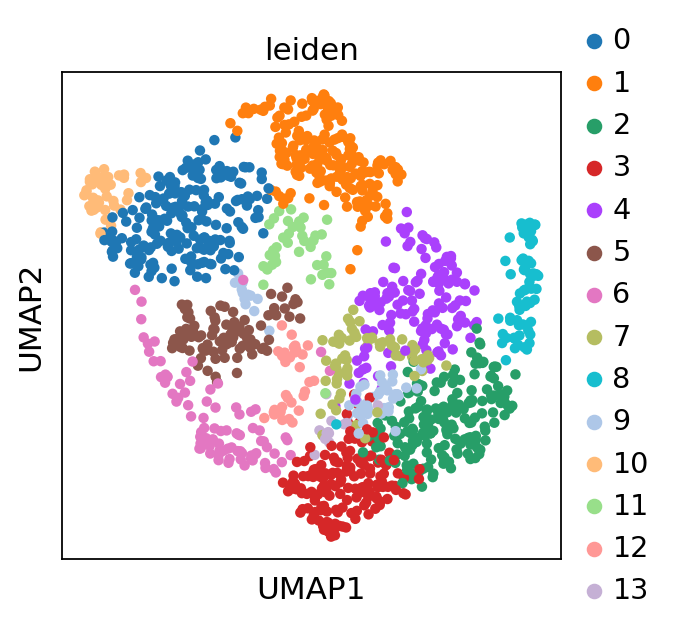

running ingest
    finished (0:00:06)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


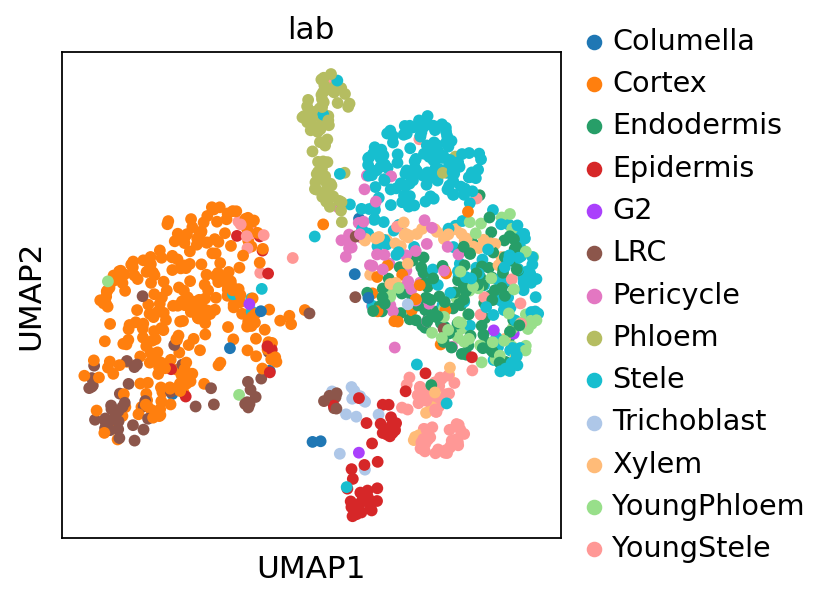

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


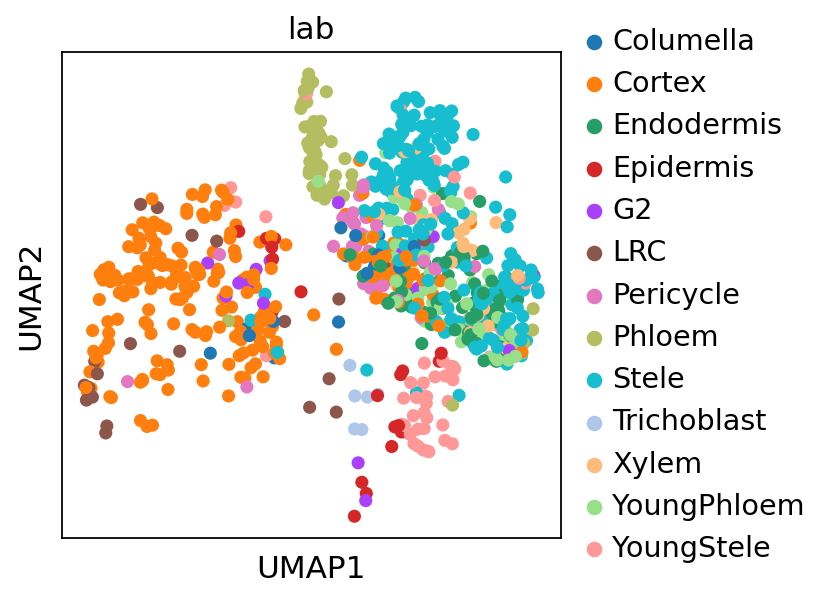

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


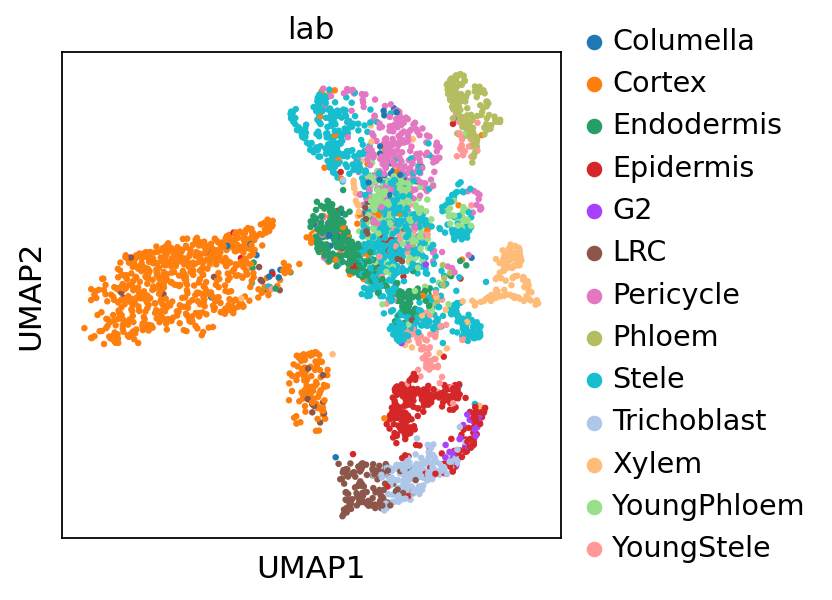

In [25]:
samples = []
for i in ["sbicolor_root10", "zmays_root2", "zmays_root3"]:
    samples.append(preprocess(i, 1))
ingest = [samples[1], samples[2]]
merged = ingest_samples(ingest)
sbi = attach_CT(samples[0], "sbicolor_root10")

make_csv()

